In [1]:
import os
import keras
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.api.models import load_model, Sequential
from keras.api.layers import Dense, Flatten, Dropout
from keras.api.optimizers import SGD
from keras.api.losses import SparseCategoricalCrossentropy
from keras import layers, activations, Model
from sklearn.metrics import confusion_matrix

2024-09-27 19:27:24.364780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 19:27:24.478575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 19:27:24.507952: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 19:27:24.687578: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 19:27:25.997717: W tensorflow/compiler/tf2

In [2]:
# We can customize the batch size, image height, and image width
batch_size  = 32
img_height  = 224
img_width   = 224
channel     = 3

image_size              = (img_height, img_width)
image_size_with_channel = (img_height, img_width, channel)

# Constant value
CHECKPOINTS = "checkpoints"
LATEST_MODEL_NAME = "latest_model.keras"

# Using default sort from VSCode
# Colon polyps, Colorectal cancer, Normal mucosa...
CLASS_ARR = ["Colon polyps", "Colorectal cancer", "Normal mucosa and vascular pattern in the large bowel"]

In [3]:
# Save the current model
def save_model(model, model_name: str = ""):
    try:
        model.save(CHECKPOINTS + os.sep + model_name + LATEST_MODEL_NAME)
    except Exception as e:
        print(e)
        raise e
    
    print("Model has succesfully saved")
    
def load_model_function(model_name):
    try:
        model_file = CHECKPOINTS + os.sep + model_name + LATEST_MODEL_NAME
        model = load_model(model_file)

        return model
    except Exception as e:
        raise e

In [4]:
def make_confusion_matrix(model: Model, validation_dataset: tf.data.Dataset):
    predictions = np.array([])
    labels = np.array([])
    categories = CLASS_ARR

    for x, y in validation_dataset:
        y_pred = model.predict(x)
        y_prediction = np.argmax(y_pred, axis=1)
        predictions = np.concatenate([predictions, y_prediction])
        labels = np.concatenate([labels, y.numpy()])
        
    plt.figure(num=69420, figsize=(plt.rcParams.get('figure.figsize')))
    sns.heatmap(confusion_matrix(y_true=labels, y_pred=predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt="d")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")

In [5]:
(train_ds, val_ds) = keras.preprocessing.image_dataset_from_directory(
    directory="datasets/Gastrovision",
    validation_split=0.2,
    subset="both",
    seed=69420,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2426 files belonging to 3 classes.
Using 1941 files for training.
Using 485 files for validation.


I0000 00:00:1727440228.274257   11779 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727440228.549178   11779 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727440228.549405   11779 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727440228.552353   11779 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [6]:
image_augmentation = {
    "training": Sequential([
        layers.RandomRotation(factor=0.2),
        layers.RandomFlip(),
    ])
}

In [7]:
# Pretrained models
inception_model = keras.applications.InceptionV3(
    include_top=False,
    classes=3,
    input_shape=(img_height, img_width, channel)
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step


In [10]:
inception_model.trainable = False

In [15]:
inputs = keras.Input(shape=image_size_with_channel)
x = image_augmentation["training"](inputs)
x = keras.applications.inception_v3.preprocess_input(x)
x = inception_model(x)
x = Flatten()(x)
outputs = Dense(units=3, activation=activations.softmax)(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │       153,603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,956,394 (83.76 MB)

 Trainable params: 153,603 (600.01 KB)

 Non-trainable params: 21,802,791 (83.17 MB)

In [16]:
def get_early_stopping():
    return keras.callbacks.EarlyStopping(patience=5)

In [17]:
model.compile(
    optimizer=SGD(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [18]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=30, callbacks=[get_early_stopping()])

Epoch 1/30


2024-09-27 19:48:00.395366: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1727441280.625705   12059 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441280.676709   12059 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441280.678565   12059 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441280.680526   12059 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441280.682489   12059 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441280.706244   12059 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441280.708644   12059 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441280.711023   12059 gpu_t

60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5529 - loss: 4.0356

W0000 00:00:1727441290.457140   12057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441290.458734   12057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441290.460387   12057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441290.462019   12057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441290.463491   12057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441290.465162   12057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441290.467036   12057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441290.468646   12057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441290.470260   12057 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5536 - loss: 4.0273

W0000 00:00:1727441292.293162   12057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441292.294647   12057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441292.296265   12057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441292.297888   12057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441292.299582   12057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441292.301127   12057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441292.302633   12057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441292.304376   12057 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441292.324474   12057 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 247ms/step - accuracy: 0.5542 - loss: 4.0192 - val_accuracy: 0.7526 - val_loss: 0.9731
Epoch 2/30


W0000 00:00:1727441298.248718   12060 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441298.250043   12060 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441298.251265   12060 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441298.252616   12060 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441298.254019   12060 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441298.255502   12060 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441298.256809   12060 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441298.258067   12060 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727441298.259350   12060 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.7193 - loss: 1.5113 - val_accuracy: 0.4784 - val_loss: 3.2479
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.7016 - loss: 1.8973 - val_accuracy: 0.4206 - val_loss: 5.0372
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.6893 - loss: 1.9290 - val_accuracy: 0.7711 - val_loss: 0.9552
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.7481 - loss: 1.4479 - val_accuracy: 0.7691 - val_loss: 0.8710
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.7473 - loss: 1.3965 - val_accuracy: 0.7649 - val_loss: 0.9363
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.7531 - loss: 1.4074 - val_accuracy: 0.7773 - val_loss: 1.0144
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.7305 - loss: 1.5602 - val_accuracy: 0.7753 - val_loss: 0.8432
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.7649 - loss: 1.2329 - val_accuracy: 0.7835 - val_

In [19]:
save_model(model, "inceptionv3_default_dataset_")

Model has succesfully saved


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2024-09-27 19:51:06.197621: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


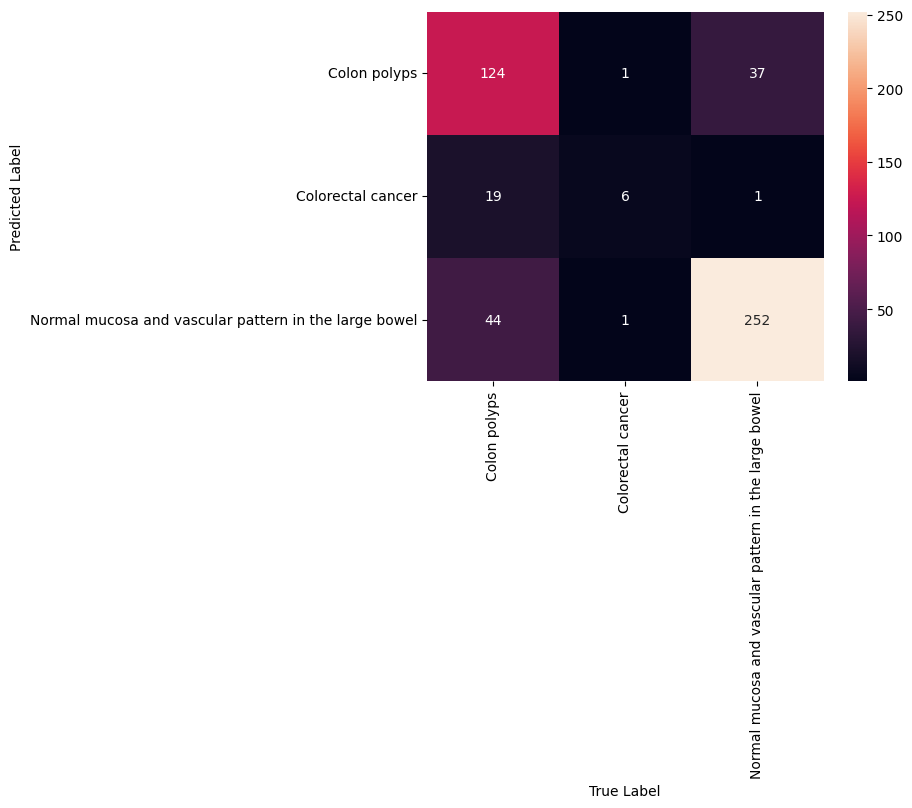

In [20]:
make_confusion_matrix(model, val_ds)